<a href="https://colab.research.google.com/github/filipecorreiabelfort/Trabalho-de-vis-o-Computacional_5_redes_trasnferlearning/blob/main/Carregar_Base_Odir_5k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Diretório das imagens
original_path = "/content/drive/MyDrive/NCA/ODIR-5K/Training Images/"

#print(original_path)

# Encontre todos os arquivos PNG no diretório e ordene-os alfabeticamente
"""pokebola = sorted(glob.glob(original_path + "*.png"))
print(len(pokebola))
print(pokebola[10])
"""

'pokebola = sorted(glob.glob(original_path + "*.png"))\nprint(len(pokebola))\nprint(pokebola[10])\n'

In [ ]:
import pandas as pd
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import tensorflow as tf


# Nome do arquivo CSV
csv_file = "/content/drive/MyDrive/NCA/ODIR-5K/data.xlsx"

# Lê o arquivo CSV em um DataFrame do pandas com o encoding 'latin1'
df = pd.read_excel(csv_file)

df


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [ ]:
import pandas as pd

# Criar arrays separados para as colunas desejadas
left_fundus = df['Left-Fundus'].tolist()
right_fundus = df['Right-Fundus'].tolist()
left_diagnostic_keywords = df['Left-Diagnostic Keywords'].tolist()
right_diagnostic_keywords = df['Right-Diagnostic Keywords'].tolist()

# Exemplo de como acessar os dados
print("Exemplo de Left-Fundus:", left_fundus[0])
print("Exemplo de Right-Fundus:", right_fundus[0])
print("Exemplo de Left-Diagnostic Keywords:", left_diagnostic_keywords[0])
print("Exemplo de Right-Diagnostic Keywords:", right_diagnostic_keywords[0])

left_diagnostic_keywords



Exemplo de Left-Fundus: 0_left.jpg
Exemplo de Right-Fundus: 0_right.jpg
Exemplo de Left-Diagnostic Keywords: cataract
Exemplo de Right-Diagnostic Keywords: normal fundus


['cataract',
 'normal fundus',
 'laser spot，moderate non proliferative retinopathy',
 'normal fundus',
 'macular epiretinal membrane',
 'moderate non proliferative retinopathy',
 'macular epiretinal membrane',
 'drusen',
 'normal fundus',
 'normal fundus',
 'epiretinal membrane',
 'moderate non proliferative retinopathy，hypertensive retinopathy',
 'retinal pigmentation',
 'pathological myopia',
 'normal fundus',
 'normal fundus',
 'normal fundus',
 'drusen',
 'pathological myopia',
 'mild nonproliferative retinopathy',
 'rhegmatogenous retinal detachment',
 'epiretinal membrane',
 'moderate non proliferative retinopathy，laser spot',
 'hypertensive retinopathy',
 'normal fundus',
 'normal fundus',
 'moderate non proliferative retinopathy',
 'normal fundus',
 'hypertensive retinopathy',
 'epiretinal membrane',
 'post laser photocoagulation，glaucoma',
 'epiretinal membrane',
 'hypertensive retinopathy',
 'normal fundus',
 'drusen',
 'pathological myopia',
 'lens dust，spotted membranous ch

In [ ]:
import cv2

def remove_border(image):

    # Converter para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar threshold para binarizar a imagem
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Encontrar contornos na imagem binarizada
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Encontrar o maior contorno (o objeto principal)
    main_contour = max(contours, key=cv2.contourArea)

    # Obter as dimensões do retângulo que envolve o contorno principal
    x, y, w, h = cv2.boundingRect(main_contour)

    # Recortar a região de interesse (ROI) da imagem original
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image



3500
3500
Imagens: 2107
labels: 2107


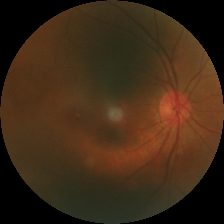

0


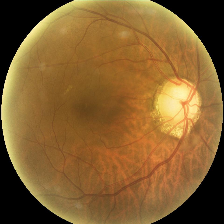

1




2107


In [ ]:
X = []
y = []

print(len(right_diagnostic_keywords))
print(len(left_diagnostic_keywords))

j = 0


# 0 - normal, 1 - retinopathy, 2 - glaucoma
for i in range(3500):
  if(right_diagnostic_keywords[i] == 'normal fundus'):
    nome_imagem = right_fundus[i]
    img = cv2.imread(original_path + nome_imagem)
    img = remove_border(img)
    img = cv2.resize(img, (224,224))

    X.append(img)
    y.append(0)
    j+=1
  if(right_diagnostic_keywords[i] == 'moderate non proliferative retinopathy') or (right_diagnostic_keywords[i] == 'mild nonproliferative retinopathy') or (right_diagnostic_keywords[i] == 'proliferative diabetic retinopathy'):
    nome_imagem = right_fundus[i]
    img = cv2.imread(original_path + nome_imagem)
    img = remove_border(img)
    img = cv2.resize(img, (224,224))

    X.append(img)
    y.append(1)
    j+=1
  if(right_diagnostic_keywords[i] == 'glaucoma'):
    nome_imagem = right_fundus[i]
    img = cv2.imread(original_path + nome_imagem)
    img = remove_border(img)
    img = cv2.resize(img, (224,224))

    X.append(img)
    y.append(2)
    j+=1

print(f"Imagens: {len(X)}")
print(f"labels: {len(y)}")

X = np.array(X)

cv2_imshow(X[0])
print(y[0])
cv2_imshow(X[3])
print(y[3])
print("\n\n\n")
print(j)

#np.save("/content/drive/MyDrive/NCA/ODIR-5K/X_odir_5k_N_D_G.npy", X)
#np.save("/content/drive/MyDrive/NCA/ODIR-5K/Y_odir_5k_N_D_G.npy", y)

